# Personal Information
**Name:** Ali Alghamdi

**Student ID:** 14988828

**Email:** ali.alghamdi@student.uva.nl

**Submitted on:** March 22nd, 2024

**GitHub Link:** https://github.com/alialghamdi/msc-thesis

# Description of this activity
In this exploratory data analysis (EDA), I delved into a rich textual dataset encapsulated within the `items` DataFrame, focusing primarily on the `cleaned_text`. My primary goal was to uncover underlying patterns, sentiments, and temporal trends inherent in the textual data. 

This comprehensive EDA offered valuable insights into the dataset's emotional and thematic landscape, demonstrating the power of textual analysis and visualization in uncovering the nuanced dynamics of written content over time.

## 1. Importing needed libraries and loading data

In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import string
import json
from ast import literal_eval 

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

plt.style.use('bmh')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alialghamdi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alialghamdi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/alialghamdi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [41]:
file_path = 'all_languages/items.json'

with open(file_path, 'r') as file:
    data = json.load(file)

def collect_labels(obj, prefix='', label_dict=None):
    if label_dict is None:
        label_dict = {}

    if isinstance(obj, dict):
        for key, value in obj.items():
            label = prefix + '.' + key if prefix else key
            label_dict[label] = type(value).__name__
            collect_labels(value, label, label_dict)
    elif isinstance(obj, list):
        for item in obj:
            collect_labels(item, prefix, label_dict)

    return label_dict

label_hierarchy = collect_labels(data)
print("Label Hierarchy:")
for label, value_type in label_hierarchy.items():
    print(f"{label}: {value_type}")

Label Hierarchy:
@type: str
@id: str
@graph: str
label: str
source: dict
source.@id: str
source.excerpts: list
source.excerpts.@id: str
source.excerpts.value: str
source.excerpts.words: list
source.author: list
source.author.@id: str
source.author.label: str
source.label: str
source.date: str
source.language: str
time: list
time.@id: str
time.label: str
time.begin: str
time.end: str
place: list
place.@id: str
place.label: str
relevantExcerpt: str
smellSource: list
smellSource.@id: str
smellSource.label: str
source.url: str
adjective: str
emotion: list
emotion.@id: str
emotion.label: str
license: str
carrier: list
carrier.@id: str
carrier.label: str
carrier.exemplifies: str
source.genre: list
source.genre.@id: str
source.genre.label: str


In [42]:
def normalize_data(entry):
    base_info = {
        'type': entry.get('@type'),
        'id': entry.get('@id'),
        'graph': entry.get('@graph'),
        'label': entry.get('label'),
        'source_id': entry.get('source', {}).get('@id'),
        'source_label': entry.get('source', {}).get('label'),
        'source_url': entry.get('source', {}).get('url'),
        'source_date': entry.get('source', {}).get('date'),
        'source_language': entry.get('source', {}).get('language'),
        'source_genre': [genre.get('label') for genre in entry.get('source', {}).get('genre', [])],
        'relevantExcerpt': entry.get('relevantExcerpt'),
        'adjective': entry.get('adjective'),
        'emotion': [emotion.get('label') for emotion in entry.get('emotion', [])],
        'license': entry.get('license'),
        'time': [{'id': time.get('@id'), 'label': time.get('label'), 'begin': time.get('begin'), 'end': time.get('end')} for time in entry.get('time', [])],
        'place': [{'id': place.get('@id'), 'label': place.get('label')} for place in entry.get('place', [])],
        'smellSource': [{'id': source.get('@id'), 'label': source.get('label')} for source in entry.get('smellSource', [])],
        'carrier': [{'id': carrier.get('@id'), 'label': carrier.get('label'), 'exemplifies': carrier.get('exemplifies')} for carrier in entry.get('carrier', [])],
    }

    rows = []
    for excerpt in entry.get('source', {}).get('excerpts', []):
        excerpt_data = {
            'excerpt_id': excerpt.get('@id'),
            'excerpt_value': excerpt.get('value'),
            'words': excerpt.get('words', [])
        }

        if not isinstance(excerpt_data['words'], list):
            excerpt_data['words'] = [excerpt_data['words']]

        row = {**base_info, **excerpt_data}
        rows.append(row)

    return rows

rows = []
for entry in data:
    rows.extend(normalize_data(entry))

items_pd = pd.DataFrame(rows)
items_pd.head()

,type,id,graph,label,source_id,source_label,source_url,source_date,source_language,source_genre,...,adjective,emotion,license,time,place,smellSource,carrier,excerpt_id,excerpt_value,words
0,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,None,1880,en,[],...,None,[],None,[{'id': 'http://data.odeuropa.eu/time/94f1e857...,"[{'id': 'https://sws.geonames.org/10179318/', ...",[],[],http://data.odeuropa.eu/source/56c5cda7-750c-5...,& # 34 ; Owd Siah waved his as he termed a thi...,"[sniffing, the party, betimes]"
1,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,None,1880,en,[],...,None,[],None,[{'id': 'http://data.odeuropa.eu/time/94f1e857...,"[{'id': 'https://sws.geonames.org/10179318/', ...",[],[],http://data.odeuropa.eu/source/56c5cda7-750c-5...,179 With her arms linked in those of Lucy and ...,"[Bartlett, perfume, scent, very odorous, of th..."
2,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,None,1880,en,[],...,None,[],None,[{'id': 'http://data.odeuropa.eu/time/94f1e857...,"[{'id': 'https://sws.geonames.org/10179318/', ...",[],[],http://data.odeuropa.eu/source/56c5cda7-750c-5...,104 pictures : Eccho forth your grones through...,"[stench, noysome, his, crawling]"
3,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,None,1880,en,[],...,None,[],None,[{'id': 'http://data.odeuropa.eu/time/94f1e857...,"[{'id': 'https://sws.geonames.org/10179318/', ...",[],[],http://data.odeuropa.eu/source/56c5cda7-750c-5...,"Nothing , perhaps , sends up the quicksilver o...",[fragrant]
4,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,None,1880,en,[],...,None,[],None,[{'id': 'http://data.odeuropa.eu/time/94f1e857...,"[{'id': 'https://sws.geonames.org/10179318/', ...",[],[],http://data.odeuropa.eu/source/56c5cda7-750c-5...,open space I sent forth a shout of joy that ec...,"[scent, thy, so much sharper]"


/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


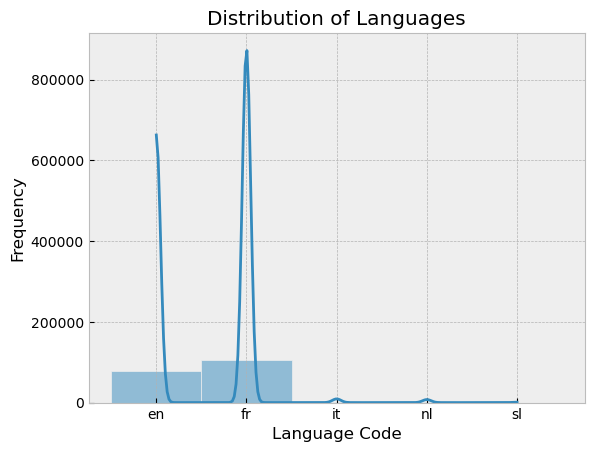

In [44]:
#Show the distribution of languages in the ME
sns.histplot(items_pd['source_language'], kde=True) 

plt.title('Distribution of Languages') 
plt.xlabel('Language Code')
plt.ylabel('Frequency')

plt.show()


## 2. Data investigation

Looking through this data, I saw how many of the texts are in English and filtered based on them. Additionally, explored some of the fields to have more understanding about it. 

In [45]:
# Filtering by only English data

en_items = items_pd[items_pd['source_language'] == 'en']
en_items = en_items.reset_index(drop=True)
en_items.count()

type               79055
id                 79055
graph              79055
label              79055
source_id          79055
source_label       79055
source_url         62626
source_date        79055
source_language    79055
source_genre       79055
relevantExcerpt    79055
adjective          44753
emotion            79055
license                0
time               79055
place              79055
smellSource        79055
carrier            79055
excerpt_id         79055
excerpt_value      79055
words              79055
dtype: int64

In [51]:
def check_empty(value):
    if isinstance(value, list) and len(value) == 0:
        return None
    return value

en_items = en_items.applymap(check_empty)
null_counts = en_items.isnull().sum()

print("Null value counts:")
print(null_counts)

/var/folders/jr/qdhrcycd4rx8yxrqjzg8czdw0000gn/T/ipykernel_63668/736648639.py:6: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  en_items = en_items.applymap(check_empty)


Null value counts:
type                   0
id                     0
graph                  0
label                  0
source_id              0
source_label           0
source_url         16429
source_date            0
source_language        0
source_genre       79055
relevantExcerpt        0
adjective          34302
emotion            78178
license            79055
time                 132
place                  0
smellSource        31630
carrier            71310
excerpt_id             0
excerpt_value          0
words                  0
dtype: int64


In [47]:
en_items.shape

(79055, 21)

In [48]:
print(en_items.isnull().sum())

type                   0
id                     0
graph                  0
label                  0
source_id              0
source_label           0
source_url         16429
source_date            0
source_language        0
source_genre           0
relevantExcerpt        0
adjective          34302
emotion                0
license            79055
time                   0
place                  0
smellSource            0
carrier                0
excerpt_id             0
excerpt_value          0
words                  0
dtype: int64


In [8]:
print(en_items.describe())

                                              type  \
count                                        79055   
unique                                           1   
top     http://data.odeuropa.eu/ontology/L11_Smell   
freq                                         79055   

                                                       id  \
count                                               79055   
unique                                                332   
top     http://data.odeuropa.eu/smell/0bfa9ffd-9610-50...   
freq                                                10498   

                                           graph    label  \
count                                      79055    79055   
unique                                         7      103   
top     http://data.odeuropa.eu/medical-heritage  perfume   
freq                                       59782    15067   

                                                source_id  \
count                                               7905

In [9]:
print(en_items['label'].value_counts())

label
perfume                       15067
[perfume, grance]             10498
smell                          7650
[odour, perfumes, ardour]      5969
odours                         5300
                              ...  
[smells, stench, nostrils]        6
stank                             5
[thyme, perfume]                  4
[odoriferous, Olfactory]          3
[odour, scents]                   2
Name: count, Length: 103, dtype: int64


In [10]:
print("Unique sources:", en_items['source_id'].nunique())
print("Unique excerpts:", en_items['excerpt_id'].nunique())

Unique sources: 304
Unique excerpts: 61732


year
1687.0     90
1691.0     19
1717.0     91
1732.0     28
1764.0     25
         ... 
1980.0      9
1981.0    286
1991.0     27
1992.0      7
2021.0     62
Name: count, Length: 126, dtype: int64


<Axes: xlabel='year'>

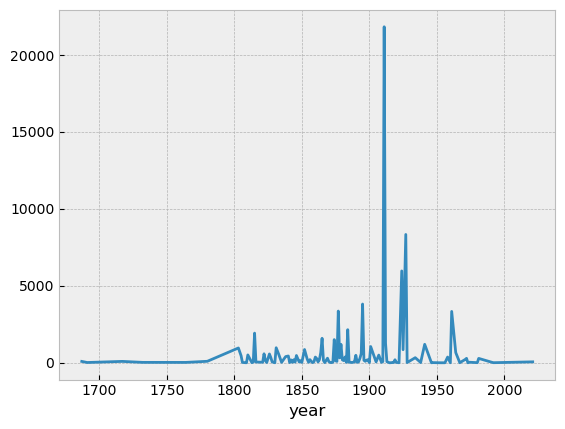

In [11]:
en_items['date'] = pd.to_datetime(en_items['source_date'], errors='coerce')
en_items['year'] = en_items['date'].dt.year
print(en_items['year'].value_counts().sort_index())

en_items['year'].value_counts().sort_index().plot(kind='line')

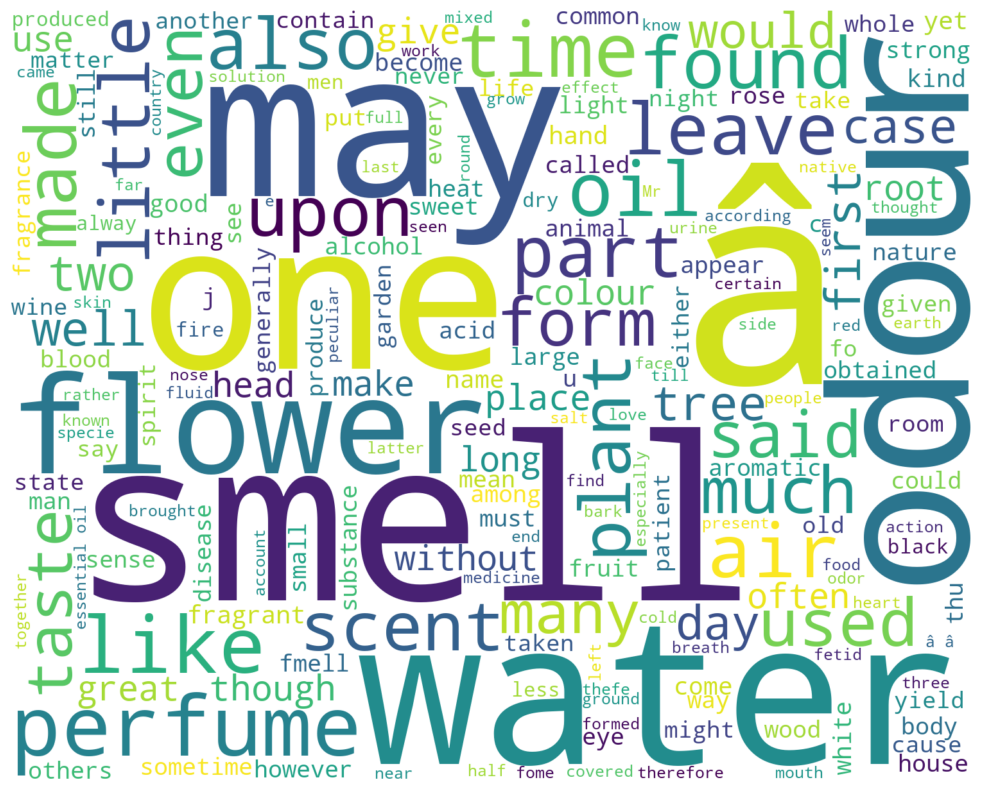

In [12]:
stop_words = stopwords.words('english')
text = ' '.join(en_items['excerpt_value'])

wordcloud = WordCloud(stopwords=stop_words, background_color="white", width=1500, height=1200).generate(text)

plt.figure(figsize=(15, 10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

count    79055.000000
mean         0.088882
std          0.181190
min         -1.000000
25%          0.000000
50%          0.075000
75%          0.191667
max          1.000000
Name: sentiment, dtype: float64


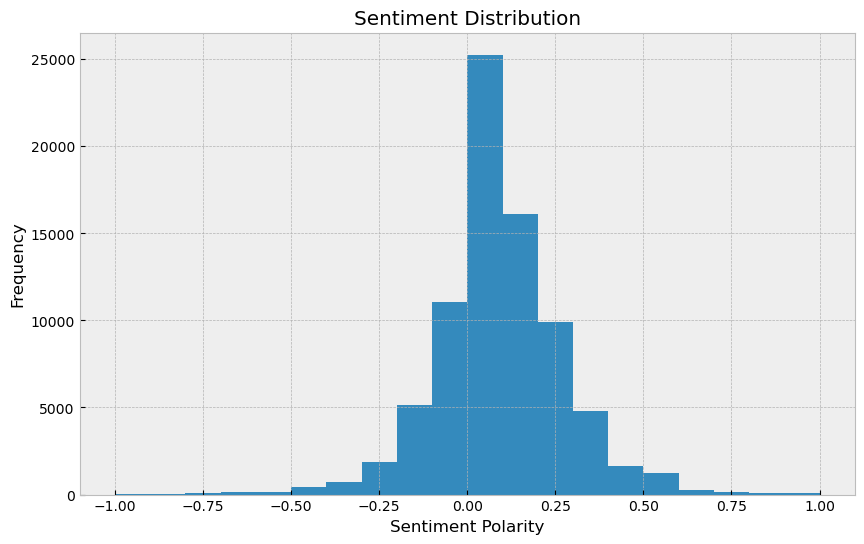

In [13]:
def get_sentiment(text):
    return TextBlob(text).sentiment.polarity

en_items['sentiment'] = en_items['excerpt_value'].apply(get_sentiment)
print(en_items['sentiment'].describe())

plt.figure(figsize=(10, 6))
en_items['sentiment'].hist(bins=20)
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment Polarity')
plt.ylabel('Frequency')
plt.show()

/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, 

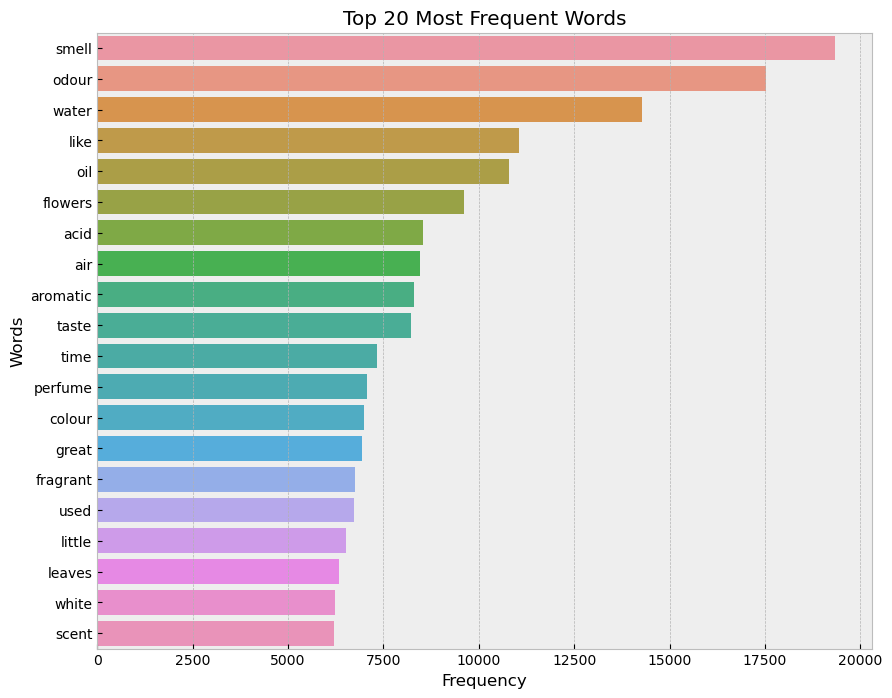

In [14]:
vectorizer = CountVectorizer(stop_words='english')
X = vectorizer.fit_transform(en_items['excerpt_value'])
word_counts = X.sum(axis=0)
words_freq = [(word, word_counts[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

top_words = words_freq[:20]
words = [word[0] for word in top_words]
counts = [word[1] for word in top_words]

plt.figure(figsize=(10, 8))
sns.barplot(x=counts, y=words)
plt.title('Top 20 Most Frequent Words')
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.show()


/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, 

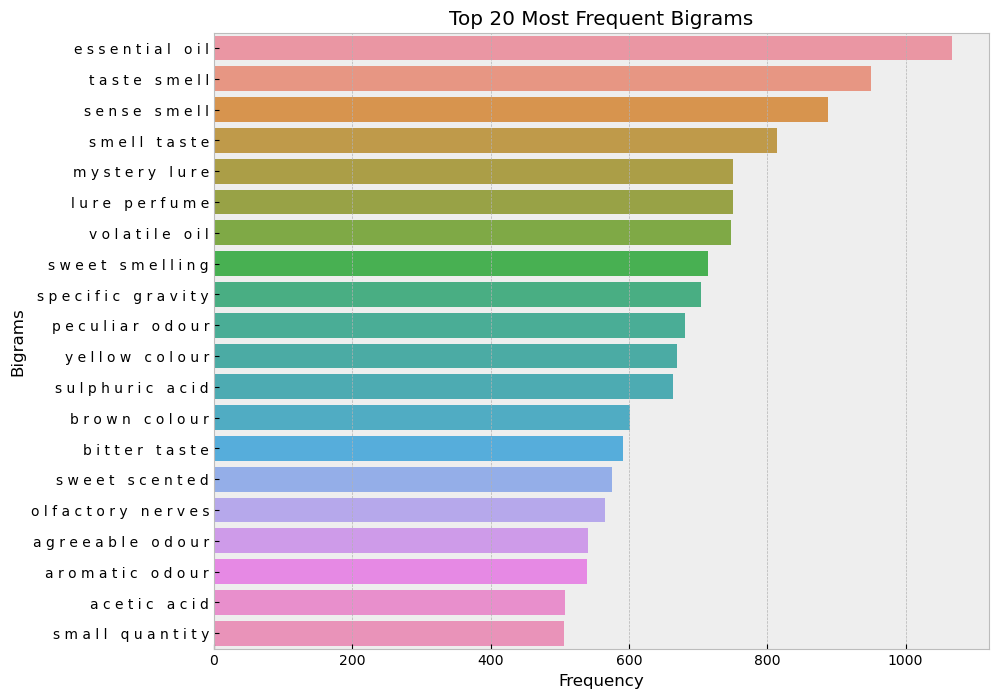

In [15]:
bigram_vectorizer = CountVectorizer(ngram_range=(2, 2), stop_words='english')
bigram_X = bigram_vectorizer.fit_transform(en_items['excerpt_value'])
bigram_counts = bigram_X.sum(axis=0)
bigram_freq = [(bigram, bigram_counts[0, idx]) for bigram, idx in bigram_vectorizer.vocabulary_.items()]
bigram_freq = sorted(bigram_freq, key=lambda x: x[1], reverse=True)
top_bigrams = bigram_freq[:20]
bigrams = [' '.join(bigram[0]) for bigram in top_bigrams]
bigram_counts = [bigram[1] for bigram in top_bigrams]

plt.figure(figsize=(10, 8))
sns.barplot(x=bigram_counts, y=bigrams)
plt.title('Top 20 Most Frequent Bigrams')
plt.xlabel('Frequency')
plt.ylabel('Bigrams')
plt.show()

/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/Users/alialghamdi/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Co

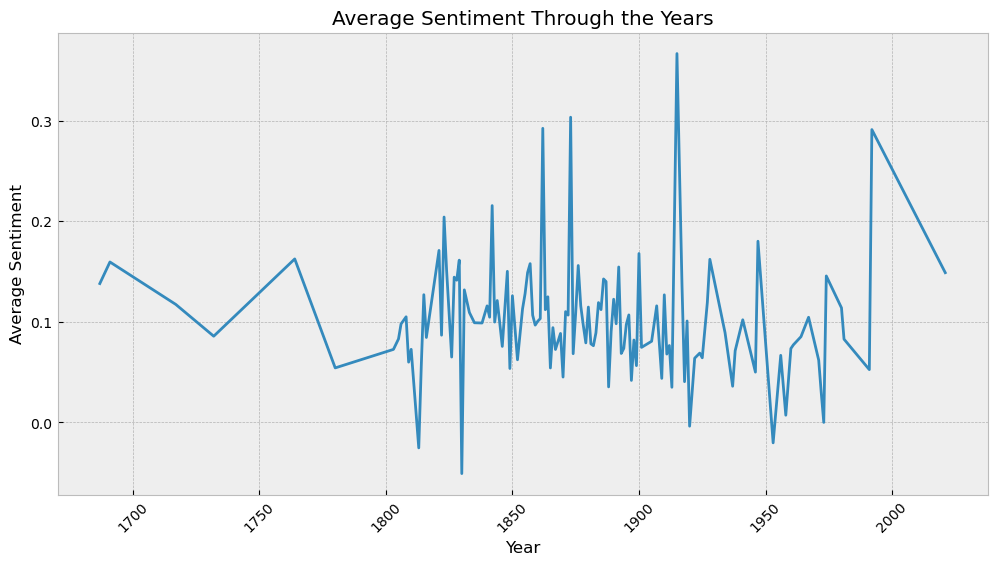

In [16]:
average_sentiment_per_year = en_items.groupby('year')['sentiment'].mean().dropna()

plt.figure(figsize=(12, 6))
sns.lineplot(data=average_sentiment_per_year)
plt.title('Average Sentiment Through the Years')
plt.xlabel('Year')
plt.ylabel('Average Sentiment')
plt.xticks(rotation=45)
plt.show()

---

# Data Cleaning 

Doing some data cleaning, while some has been done earlier in the investigation to understand, we are making the data better to use. 

In [17]:
en_items.head()

,type,id,graph,label,source_id,source_label,source_url,source_date,source_language,relevantExcerpt,excerpt_id,excerpt_value,words,date,year,sentiment
0,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,& # 34 ; Owd Siah waved his as he termed a thi...,"[sniffing, the party, betimes]",1880-01-01,1880.0,0.088636
1,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,179 With her arms linked in those of Lucy and ...,"[Bartlett, perfume, scent, very odorous, of th...",1880-01-01,1880.0,-0.071652
2,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,104 pictures : Eccho forth your grones through...,"[stench, noysome, his, crawling]",1880-01-01,1880.0,-0.062500
3,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,"Nothing , perhaps , sends up the quicksilver o...",[fragrant],1880-01-01,1880.0,0.083333
4,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,open space I sent forth a shout of joy that ec...,"[scent, thy, so much sharper]",1880-01-01,1880.0,0.202273


In [18]:
def cleaning(text):
    # Lowercasing
    text = text.lower()
    
    # No punctuation
    text = text.translate(str.maketrans('', '', string.punctuation))
    
    # No stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    
    # Lemmatize text
    lemmatizer = WordNetLemmatizer()
    word_tokens = word_tokenize(text)
    text = ' '.join([lemmatizer.lemmatize(w) for w in word_tokens])
    
    return text

en_items['excerpt_value_cleaned'] = en_items['excerpt_value'].apply(cleaning)
en_items['source_label_cleaned'] = en_items['source_label'].apply(cleaning)

print(en_items[['excerpt_value_cleaned', 'source_label_cleaned']].head())

                               excerpt_value_cleaned  \
0  34 owd siah waved termed thick knotty meet meb...   
1  179 arm linked lucy phœbe louise following lit...   
2  104 picture eccho forth grones hollow truncke ...   
3  nothing perhaps sends quicksilver sphits highe...   
4  open space sent forth shout joy echoed mountai...   

                                source_label_cleaned  
0  geschichte der stadt und bäder zu baden canto...  
1  geschichte der stadt und bäder zu baden canto...  
2  geschichte der stadt und bäder zu baden canto...  
3  geschichte der stadt und bäder zu baden canto...  
4  geschichte der stadt und bäder zu baden canto...  


In [19]:
en_items.isnull().sum()

type                        0
id                          0
graph                       0
label                       0
source_id                   0
source_label                0
source_url                  0
source_date                 0
source_language             0
relevantExcerpt             0
excerpt_id                  0
excerpt_value               0
words                       0
date                     1143
year                     1143
sentiment                   0
excerpt_value_cleaned       0
source_label_cleaned        0
dtype: int64

In [20]:
# Find rows where 'date' is NaT after conversion
nat_rows = en_items[en_items['date'].isna()] 

# Print these rows to investigate the 'source_date' values
print(nat_rows[['source_date']])

      source_date
5976         1634
5977         1634
5978         1634
5979         1634
5980         1634
...           ...
78599     XXXX-05
78600     XXXX-05
78601     XXXX-05
78602     XXXX-05
78603        18XX

[1143 rows x 1 columns]


In [21]:
non_convertible = en_items['source_date'][~en_items['source_date'].str.match(r'^\d{4}$')]
print(non_convertible)

24303    1930?/1940?
24304    1930?/1940?
24305    1930?/1940?
24306    1930?/1940?
24307    1930?/1940?
            ...     
78599        XXXX-05
78600        XXXX-05
78601        XXXX-05
78602        XXXX-05
78603           18XX
Name: source_date, Length: 182, dtype: object


In [22]:
en_items = en_items[en_items['source_date'].str.match(r'^\d{4}$')]

print(en_items.shape)
print(en_items.head())

(78873, 18)
                                         type  \
0  http://data.odeuropa.eu/ontology/L11_Smell   
1  http://data.odeuropa.eu/ontology/L11_Smell   
2  http://data.odeuropa.eu/ontology/L11_Smell   
3  http://data.odeuropa.eu/ontology/L11_Smell   
4  http://data.odeuropa.eu/ontology/L11_Smell   

                                                  id  \
0  http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...   
1  http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...   
2  http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...   
3  http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...   
4  http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...   

                                     graph  label  \
0  http://data.odeuropa.eu/british-library  smell   
1  http://data.odeuropa.eu/british-library  smell   
2  http://data.odeuropa.eu/british-library  smell   
3  http://data.odeuropa.eu/british-library  smell   
4  http://data.odeuropa.eu/british-library  smell   

                                     

In [23]:
en_items['year'] = en_items['source_date'].astype(int)

en_items.isnull().sum()

type                       0
id                         0
graph                      0
label                      0
source_id                  0
source_label               0
source_url                 0
source_date                0
source_language            0
relevantExcerpt            0
excerpt_id                 0
excerpt_value              0
words                      0
date                     961
year                       0
sentiment                  0
excerpt_value_cleaned      0
source_label_cleaned       0
dtype: int64

In [24]:
en_items.drop('date', axis=1, inplace=True)

In [25]:
en_items.head()

,type,id,graph,label,source_id,source_label,source_url,source_date,source_language,relevantExcerpt,excerpt_id,excerpt_value,words,year,sentiment,excerpt_value_cleaned,source_label_cleaned
0,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,& # 34 ; Owd Siah waved his as he termed a thi...,"[sniffing, the party, betimes]",1880,0.088636,34 owd siah waved termed thick knotty meet meb...,geschichte der stadt und bäder zu baden canto...
1,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,179 With her arms linked in those of Lucy and ...,"[Bartlett, perfume, scent, very odorous, of th...",1880,-0.071652,179 arm linked lucy phœbe louise following lit...,geschichte der stadt und bäder zu baden canto...
2,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,104 pictures : Eccho forth your grones through...,"[stench, noysome, his, crawling]",1880,-0.062500,104 picture eccho forth grones hollow truncke ...,geschichte der stadt und bäder zu baden canto...
3,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,"Nothing , perhaps , sends up the quicksilver o...",[fragrant],1880,0.083333,nothing perhaps sends quicksilver sphits highe...,geschichte der stadt und bäder zu baden canto...
4,http://data.odeuropa.eu/ontology/L11_Smell,http://data.odeuropa.eu/smell/a09e1c3c-f023-5e...,http://data.odeuropa.eu/british-library,smell,http://data.odeuropa.eu/source/56c5cda7-750c-5...,Geschichte der Stadt und Bäder zu Baden [in C...,,1880,en,http://data.odeuropa.eu/source/56c5cda7-750c-5...,http://data.odeuropa.eu/source/56c5cda7-750c-5...,open space I sent forth a shout of joy that ec...,"[scent, thy, so much sharper]",1880,0.202273,open space sent forth shout joy echoed mountai...,geschichte der stadt und bäder zu baden canto...


In [29]:
file_path = 'all_languages/items.json'

with open(file_path, 'r') as file:
    data = json.load(file)

def collect_labels(obj, prefix='', label_dict=None):
    if label_dict is None:
        label_dict = {}

    if isinstance(obj, dict):
        for key, value in obj.items():
            label = prefix + '.' + key if prefix else key
            label_dict[label] = type(value).__name__
            collect_labels(value, label, label_dict)
    elif isinstance(obj, list):
        for item in obj:
            collect_labels(item, prefix, label_dict)

    return label_dict

label_hierarchy = collect_labels(data)
print("Label Hierarchy:")
for label, value_type in label_hierarchy.items():
    print(f"{label}: {value_type}")

Label Hierarchy:
@type: str
@id: str
@graph: str
label: str
source: dict
source.@id: str
source.excerpts: list
source.excerpts.@id: str
source.excerpts.value: str
source.excerpts.words: list
source.author: list
source.author.@id: str
source.author.label: str
source.label: str
source.date: str
source.language: str
time: list
time.@id: str
time.label: str
time.begin: str
time.end: str
place: list
place.@id: str
place.label: str
relevantExcerpt: str
smellSource: list
smellSource.@id: str
smellSource.label: str
source.url: str
adjective: str
emotion: list
emotion.@id: str
emotion.label: str
license: str
carrier: list
carrier.@id: str
carrier.label: str
carrier.exemplifies: str
source.genre: list
source.genre.@id: str
source.genre.label: str
